<a href="https://colab.research.google.com/github/youinuk/qiskit_study/blob/main/qcrg_study_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

!source /content/drive/MyDrive/colab_env/bin/activate

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

## Week 3: 양자 오류 보정
### 문제 1: "비트 플립 오류 탐지"
```python
# 3큐비트 비트 플립 코드를 구현하여 다음 시나리오 해결:

# 요구사항:
# 1. 다음 상태들을 인코딩:
#    - |0⟩ → |000⟩
#    - |1⟩ → |111⟩
#    - |+⟩ → (|000⟩ + |111⟩)/√2
# 2. 각각의 경우에 대해:
#    - 첫 번째 큐비트에 X 오류 적용
#    - 두 번째 큐비트에 X 오류 적용
#    - 세 번째 큐비트에 X 오류 적용
# 3. 오류 신드롬 측정 및 교정 수행
# 4. 각 단계의 상태 충실도 계산
```

In [ ]:
# Qiskit imports
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
MY_API_TOKEN="xxx"

QiskitRuntimeService.save_account(channel="ibm_quantum", token=MY_API_TOKEN, overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")

In [ ]:
num_qubits = 5
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend

<IBMBackend('ibm_brisbane')>

In [2]:
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3, name="data")
creg_syndrome = ClassicalRegister(2, name="syndrome")
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc():
    """Build a typical error correction circuit"""
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

def initialize_qubits(circuit: QuantumCircuit):
    """Initialize qubit to |1>"""
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit

def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit:
    """Encode bit-flip. This is done by simply adding a cx"""
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit

def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure):
    """
        Measure the syndrome by measuring the parity.
        We reset our ancilla qubits after measuring the stabilizer
        so we can reuse them for repeated stabilizer measurements.
        Because we have already observed the state of the qubit,
        we can write the conditional reset protocol directly to
        avoid another round of qubit measurement if we used
        the `reset` instruction.
    """
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    with circuit.if_test((creg_syndrome[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_syndrome[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit

def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    """We can detect where an error occurred and correct our state"""
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit

def apply_final_readout(circuit, qreg_data, creg_data):
    """Read out the final measurements"""
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

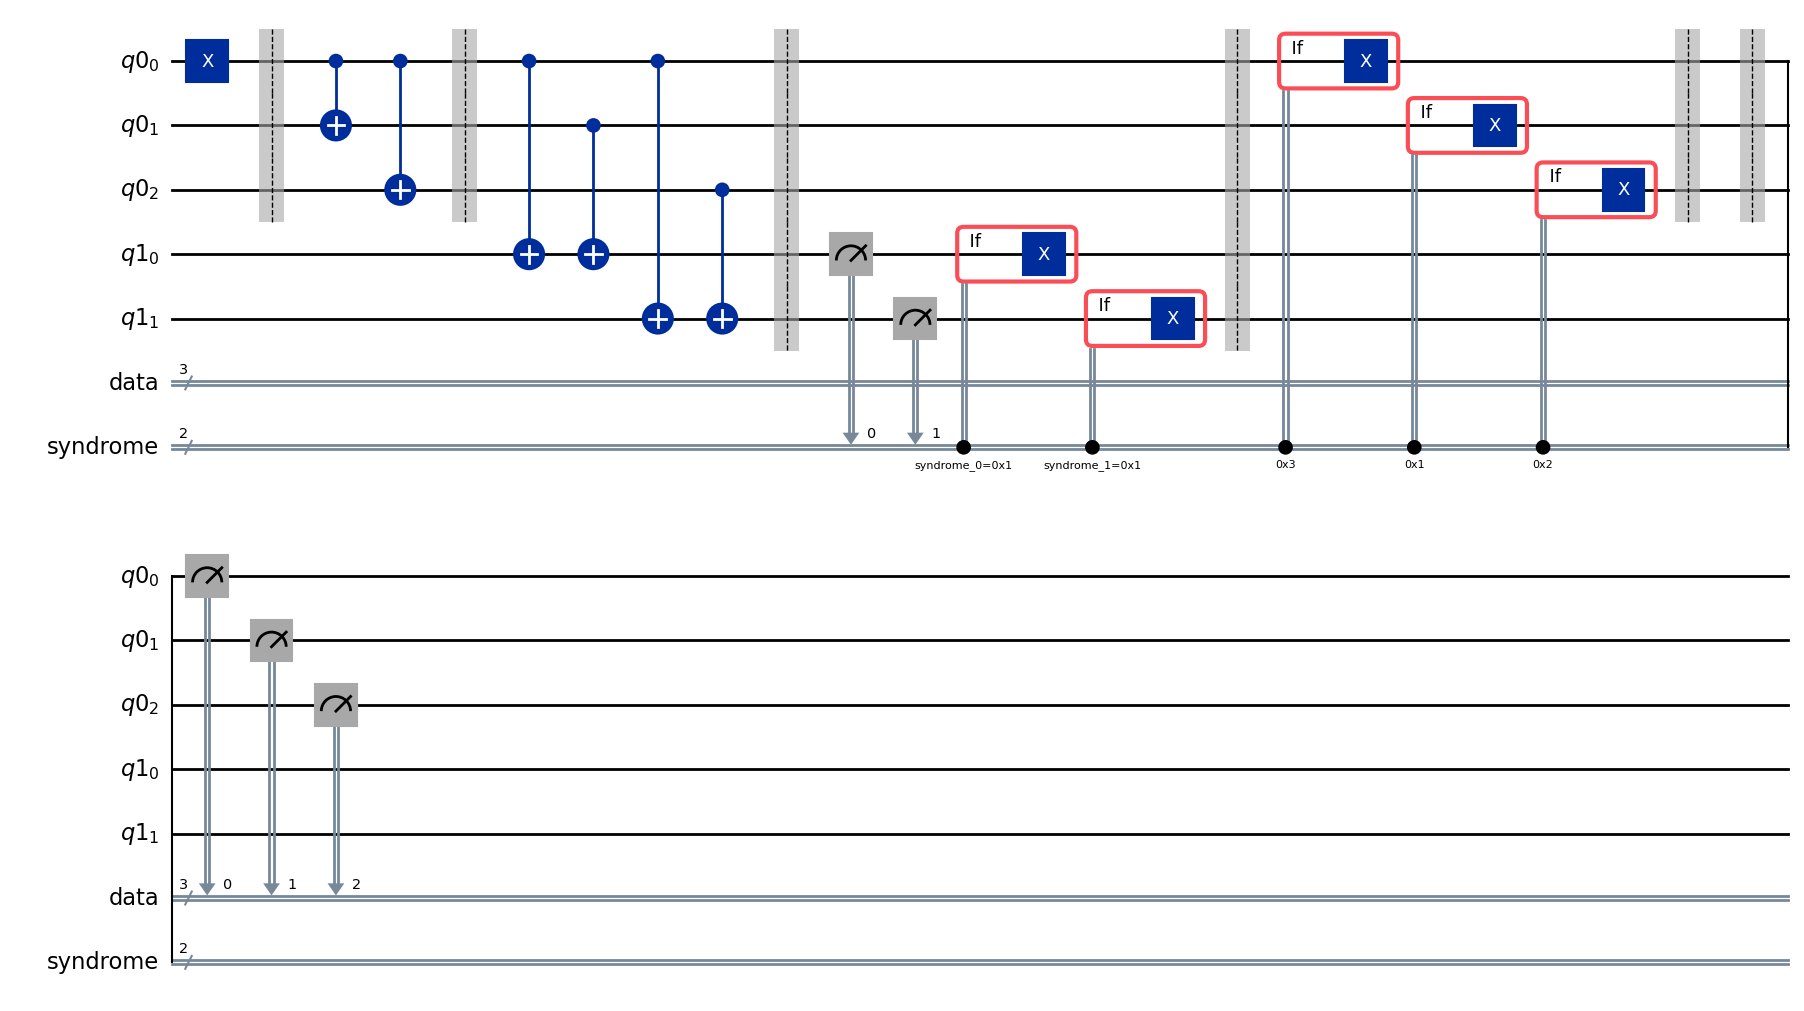

In [ ]:
def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit:

    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)

    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)

    circuit = apply_final_readout(circuit,  qreg_data, creg_data)
    return circuit

circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style='iqp')

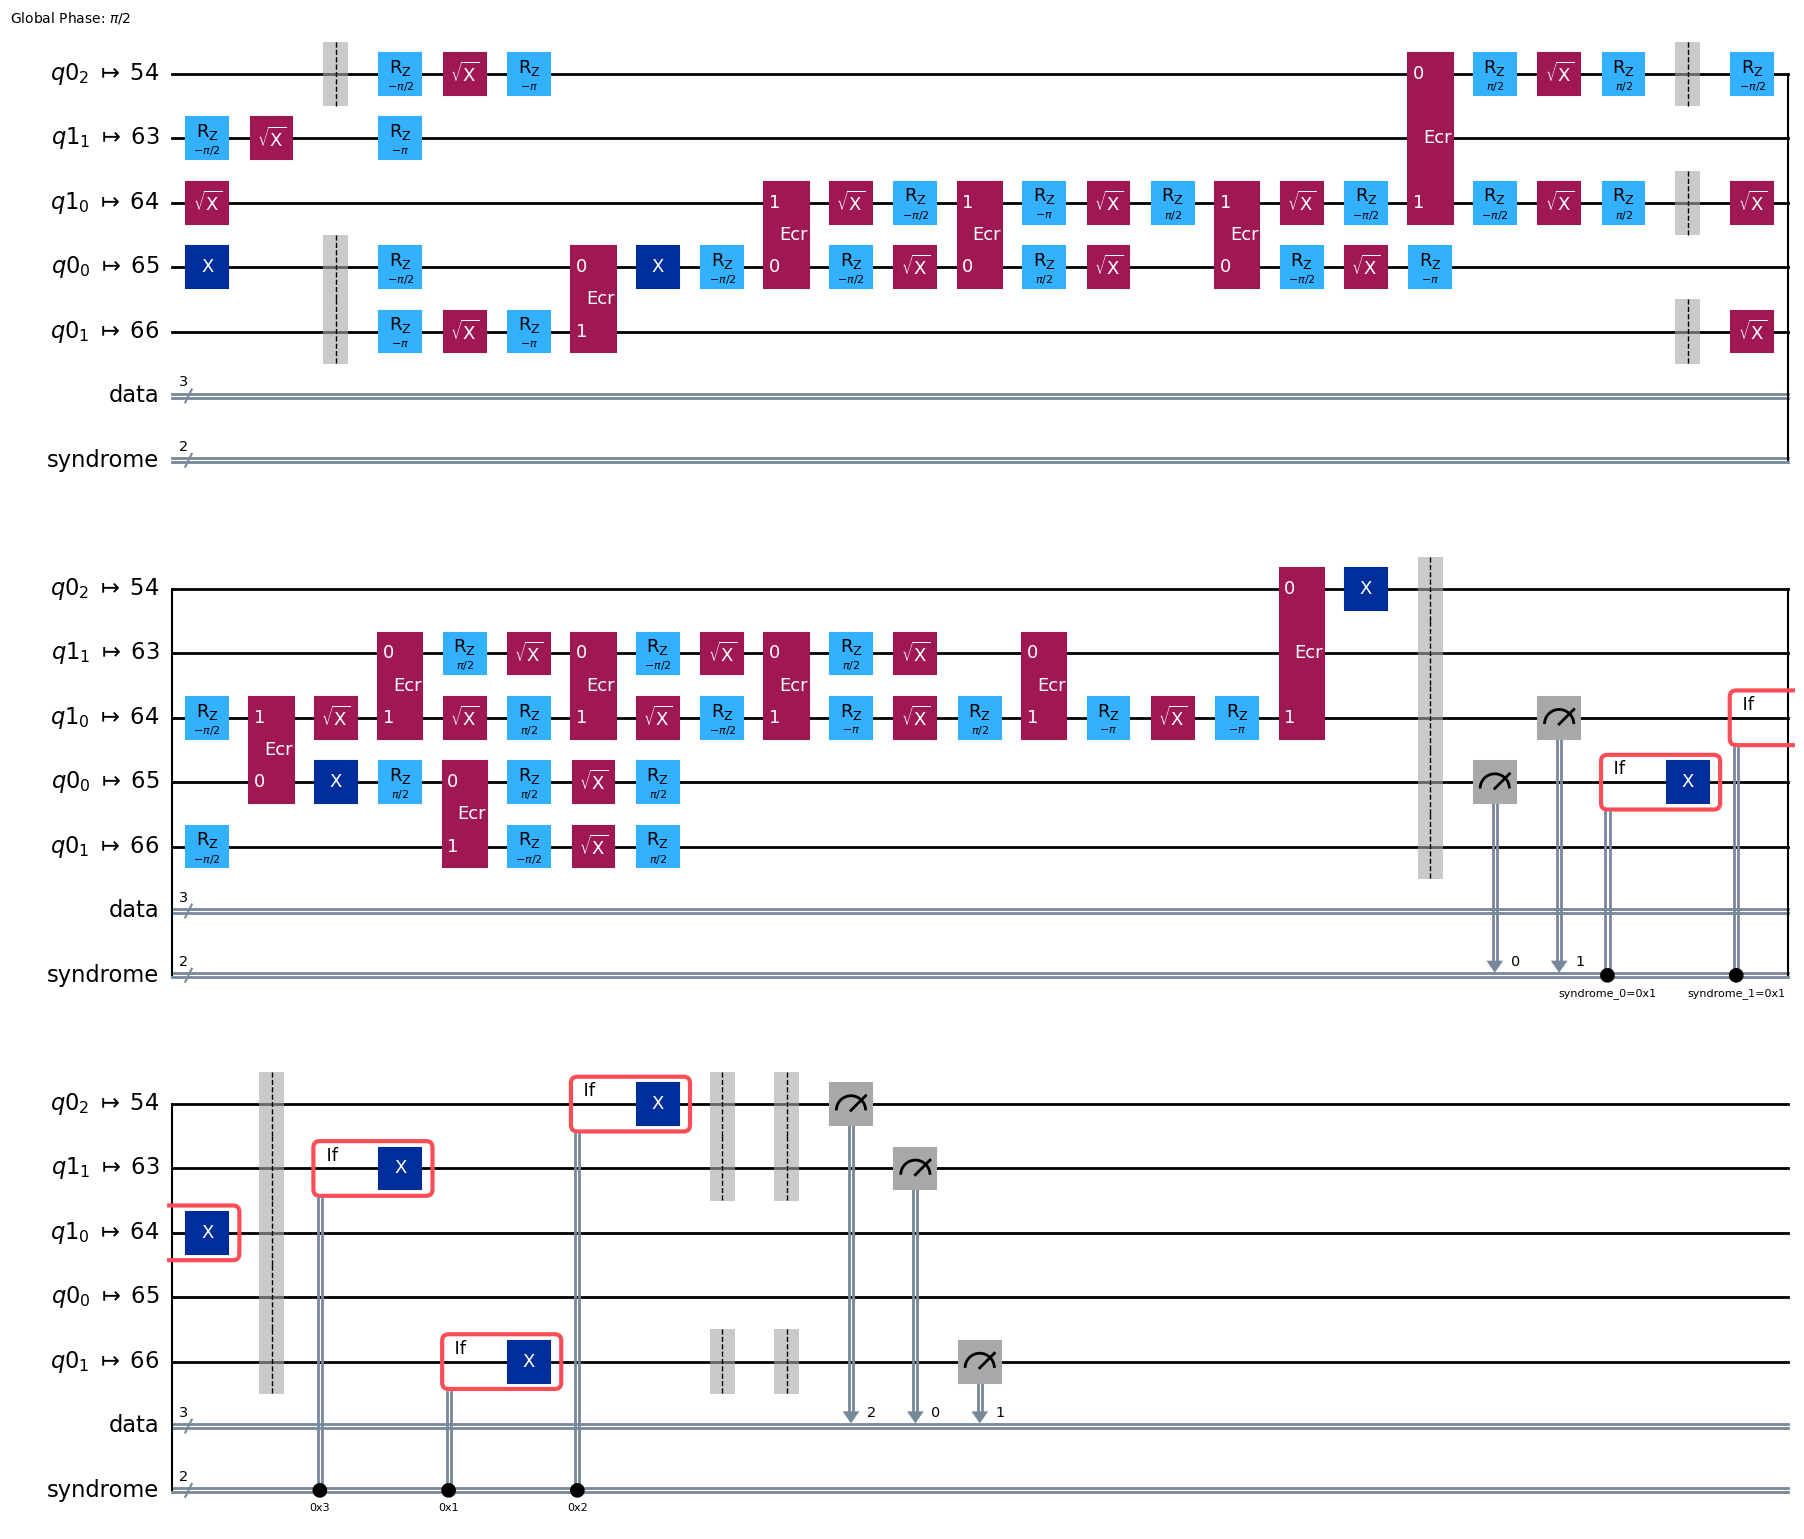

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [ ]:
sampler_with_correction = Sampler(backend)
job_with_correction = sampler_with_correction.run([isa_circuit])
result_with_correction = job_with_correction.result()[0]

In [ ]:
corrected_data_result = result_with_correction.data.data.get_counts()
corrected_syndrome_result = result_with_correction.data.syndrome.get_counts()

print(f"Data (corrected):\n{corrected_data_result}")
print(f"Syndrome (corrected):\n{corrected_syndrome_result}")

Data (corrected):
{'001': 258, '111': 1609, '100': 179, '101': 1121, '010': 267, '110': 247, '011': 293, '000': 122}
Syndrome (corrected):
{'00': 1779, '10': 309, '01': 1712, '11': 296}


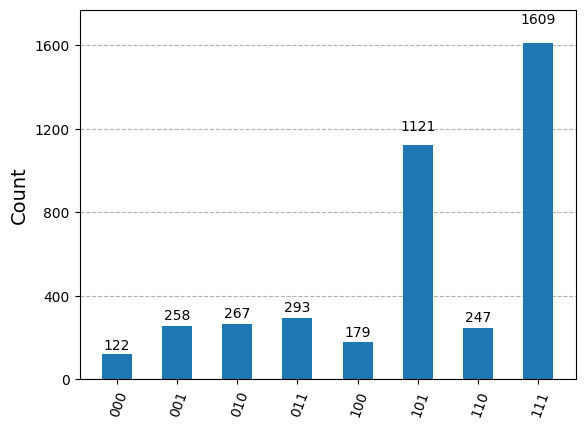

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(corrected_data_result)

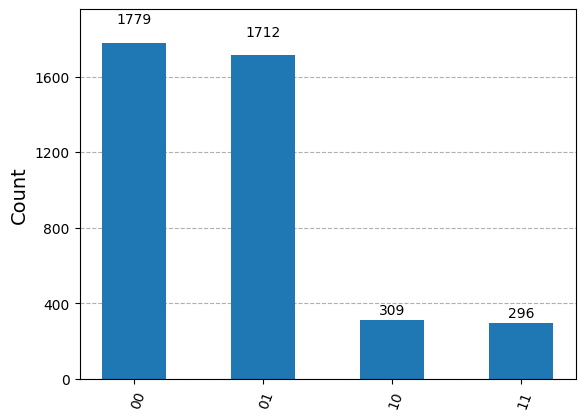

In [ ]:
plot_histogram(corrected_syndrome_result)

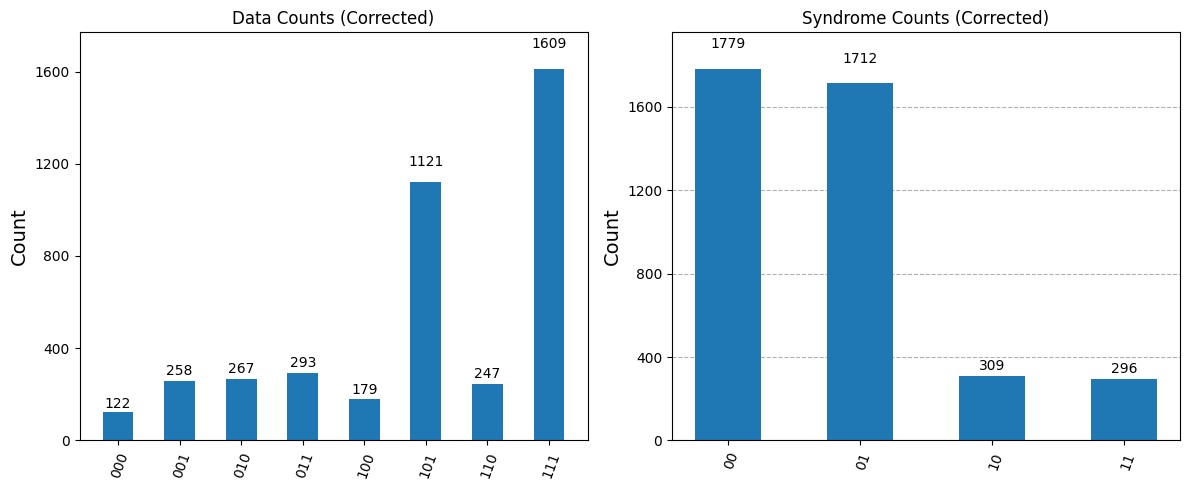

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_histogram(corrected_data_result, ax=axes[0])
axes[0].set_title("Data Counts (Corrected)")

plot_histogram(corrected_syndrome_result, ax=axes[1])
axes[1].set_title("Syndrome Counts (Corrected)")

plt.tight_layout()
plt.show()

In [10]:
def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials.")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials.")

In [ ]:
# success_trials: 오류가 성공적으로 교정된 횟수.
# failed_trials: 오류 교정에 실패한 횟수.
# error_correction_events: 오류를 탐지하고 교정한 횟수.

In [ ]:
# corrected marginalized results
print(f'Completed bit code experiment data measurement counts (corrected): {corrected_data_result}')
print(f'Completed bit code experiment syndrome measurement counts (corrected): {corrected_syndrome_result}')
decode_result(corrected_data_result, corrected_syndrome_result)

Completed bit code experiment data measurement counts (corrected): {'001': 258, '111': 1609, '100': 179, '101': 1121, '010': 267, '110': 247, '011': 293, '000': 122}
Completed bit code experiment syndrome measurement counts (corrected): {'00': 1779, '10': 309, '01': 1712, '11': 296}
Bit flip errors were detected/corrected on 2317/4096 trials.
A final parity error was detected on 2365/4096 trials.


# apply_correction=False

In [ ]:
no_correction_circuit = build_error_correction_sequence(apply_correction=False)

isa_no_correction_circuit = pm.run(no_correction_circuit)

In [ ]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run([isa_no_correction_circuit])
result_no_correction = job_no_correction.result()[0]

In [ ]:
data_result = result_no_correction.data.data.get_counts()
marginalized_syndrome_result = result_no_correction.data.syndrome.get_counts()

print(f"Data (no correction):\n{data_result}")
print(f"Syndrome (no correction):\n{marginalized_syndrome_result}")

Data (no correction):
{'101': 441, '111': 3006, '010': 96, '110': 109, '001': 37, '100': 20, '011': 289, '000': 98}
Syndrome (no correction):
{'01': 925, '00': 2914, '11': 74, '10': 183}


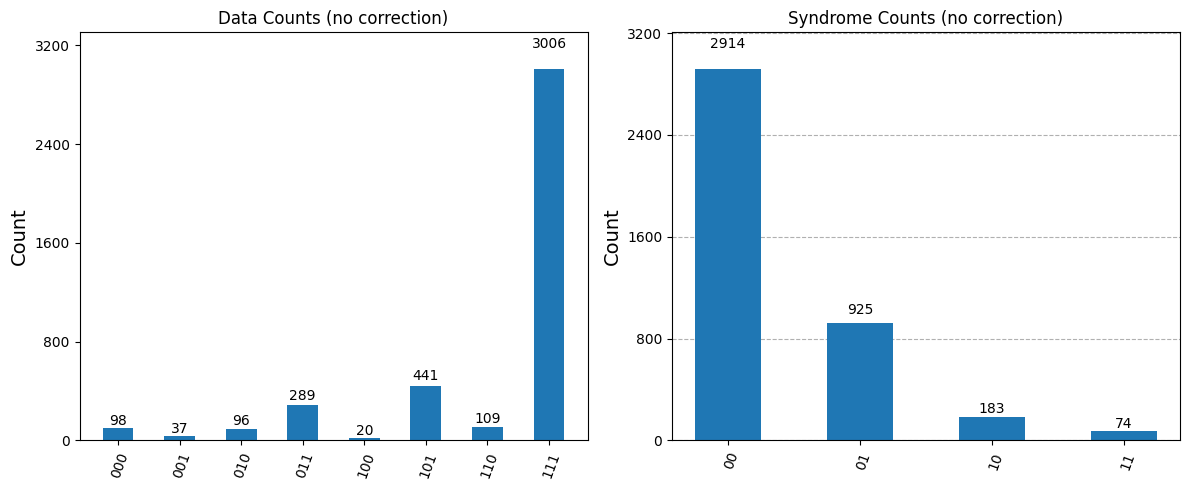

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_histogram(data_result, ax=axes[0])
axes[0].set_title("Data Counts (no correction)")

plot_histogram(marginalized_syndrome_result, ax=axes[1])
axes[1].set_title("Syndrome Counts (no correction)")

plt.tight_layout()
plt.show()

In [ ]:
# non-corrected marginalized results
print(f'Completed bit code experiment data measurement counts (no correction): {data_result}')
print(f'Completed bit code experiment syndrome measurement counts (no correction): {marginalized_syndrome_result}')
decode_result(data_result, marginalized_syndrome_result)

Completed bit code experiment data measurement counts (no correction): {'101': 441, '111': 3006, '010': 96, '110': 109, '001': 37, '100': 20, '011': 289, '000': 98}
Completed bit code experiment syndrome measurement counts (no correction): {'01': 925, '00': 2914, '11': 74, '10': 183}
Bit flip errors were detected/corrected on 1182/4096 trials.
A final parity error was detected on 992/4096 trials.


## Simulation

In [ ]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.1 MB/s eta 0:00:00


In [4]:
pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=ec6af9464bdb79215ed73663f15e95c92844cfea2a1b7edeaf31e42479028473
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


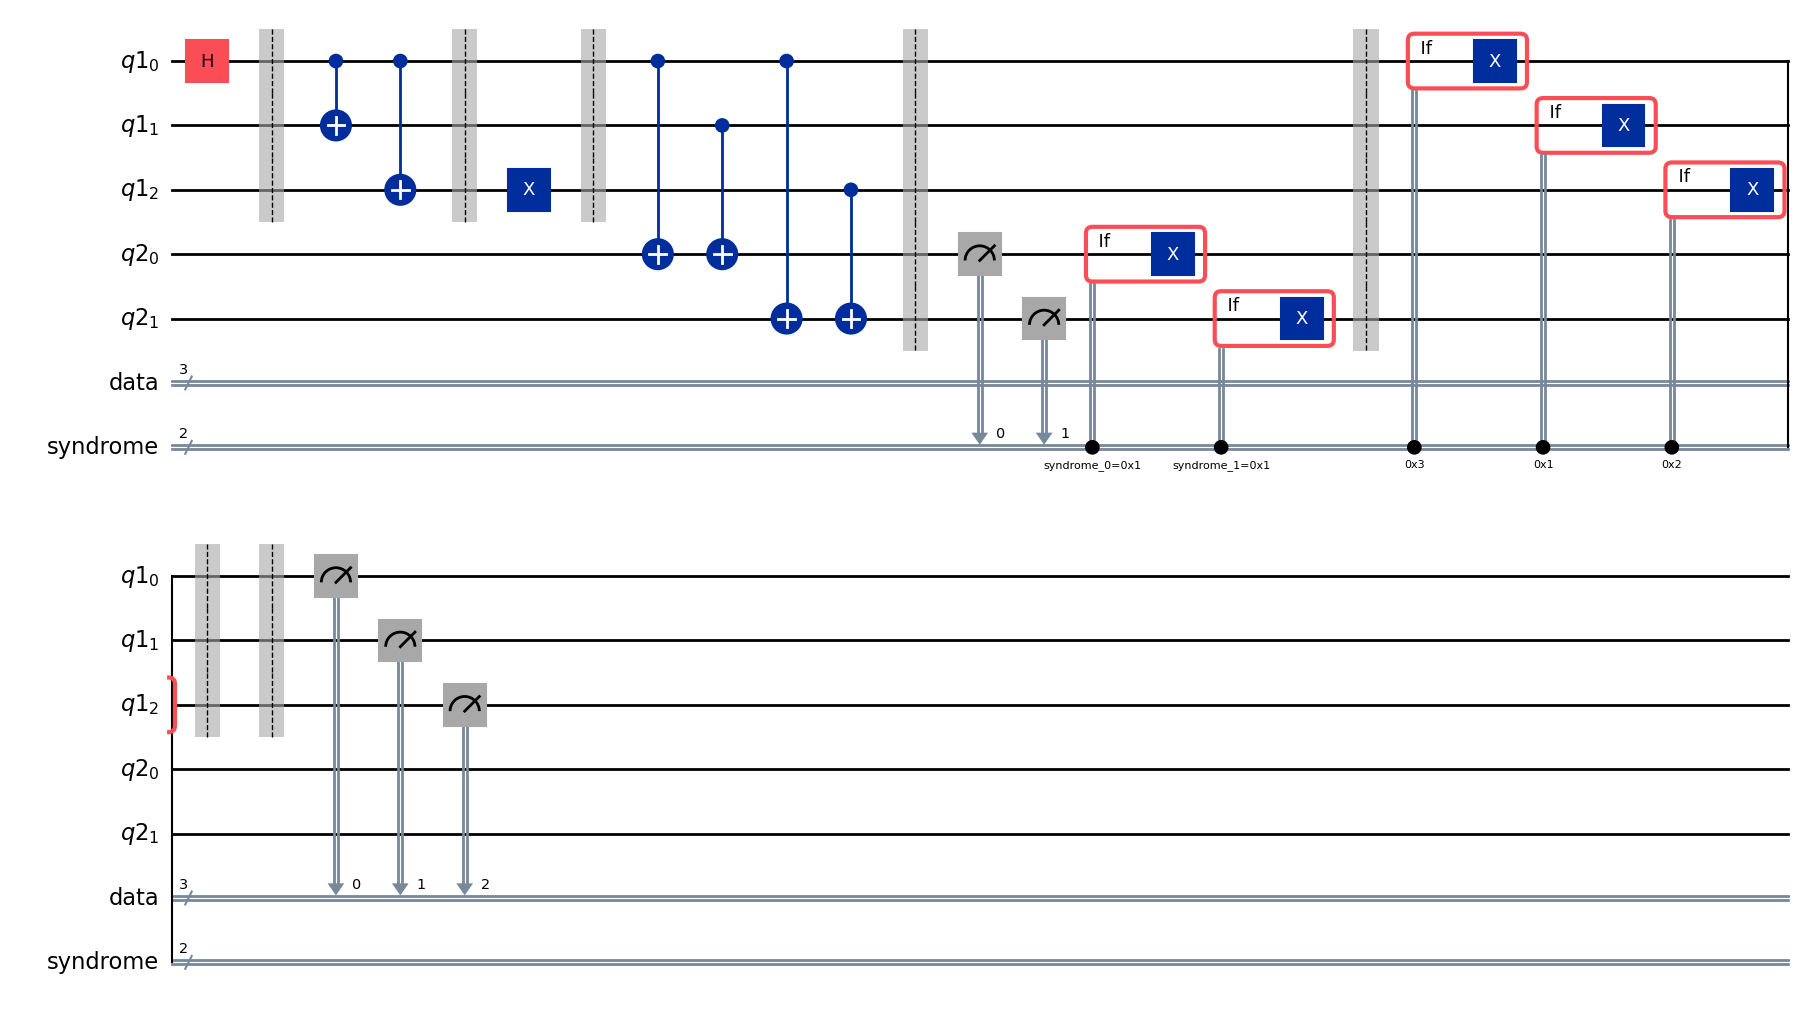

In [6]:
import numpy as np
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def initialize_qubits(circuit, init_state):
    if init_state == 0: # initialize qubit to |0>
        pass
    elif init_state == 1: # initialize qubit to |1>
        circuit.x(qreg_data[0])
    elif init_state == 2: # to |+>
        circuit.h(qreg_data[0])
    elif init_state == 3: # to |->
        circuit.x(qreg_data[0])
        circuit.h(qreg_data[0])
    else:
        raise ValueError("Invalid initialization state. Must be 0, 1, 2, or 3.")
    circuit.barrier(qreg_data)
    return circuit

def error_occured(circuit: QuantumCircuit):
    ab = np.random.randint(0, 3)
    circuit.x(qreg_data[ab])
    circuit.barrier(qreg_data)
    return circuit

def simulate_error_correction_sequence(apply_correction: bool, init_state) -> QuantumCircuit:

    circuit = build_qc()
    circuit = initialize_qubits(circuit, init_state)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = error_occured(circuit)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)

    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)

    circuit = apply_final_readout(circuit,  qreg_data, creg_data)
    return circuit

circuit = simulate_error_correction_sequence(True, 2) # init_state = |+>
circuit.draw(output="mpl", style='iqp')

In [21]:
def simulation_result(circuit, apply_correction: bool):

    simulator = AerSimulator(method='statevector')

    compiled_circuit = transpile(circuit, simulator)

    job = simulator.run(compiled_circuit)

    result = job.result()

    counts = result.get_counts()

    # Initialize dictionaries to store the results
    data_result = {}
    syndrome_result = {}

    input_data = counts.items()

    # Loop through the input to process keys and values
    for key, value in input_data:
        # Split the key into syndrome and data parts
        syndrome, data = key.split()

        # Update data_counts dictionary
        if data in data_result:
            data_result[data] += value
        else:
            data_result[data] = value

        # Update syndrome_counts dictionary
        if syndrome in syndrome_result:
            syndrome_result[syndrome] += value
        else:
            syndrome_result[syndrome] = value

    print(input_data)
    if apply_correction:
        correction = '(Corrected)'
    else:
        correction = '(No correction)'

    print(f"Data {correction}:\n{data_result}")
    print(f"Syndrome {correction}:\n{syndrome_result}")

    return data_result, syndrome_result

In [22]:
data_result, syndrome_result = simulation_result(circuit, True)

dict_items([('10 000', 486), ('10 111', 538)])
Data (Corrected):
{'000': 486, '111': 538}
Syndrome (Corrected):
{'10': 1024}


In [23]:
def plot_result(data_result, syndrome_result, apply_correction: bool):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    if apply_correction:
        correction = '(Corrected)'
    else:
        correction = '(No correction)'
    plot_histogram(data_result, ax=axes[0])
    axes[0].set_title(f"Data Counts {correction}")

    plot_histogram(syndrome_result, ax=axes[1])
    axes[1].set_title(f"Syndrome Counts {correction}")

    plt.tight_layout()
    plt.show()

    return data_result, syndrome_result

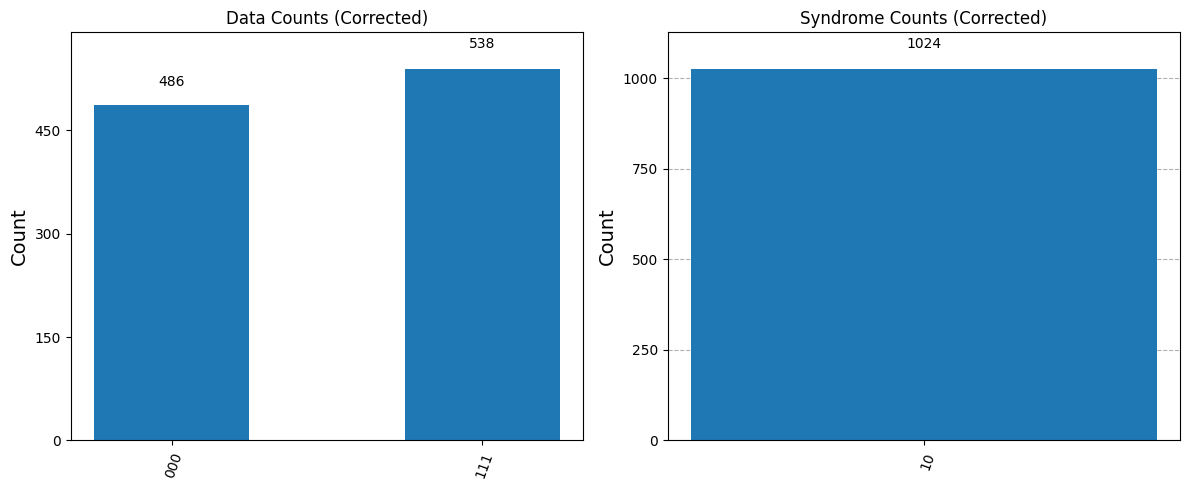

In [25]:
data_result, syndrome_result = plot_result(data_result, syndrome_result, True)

In [26]:
print(f'Completed bit code experiment data measurement counts (corrected): {data_result}')
print(f'Completed bit code experiment syndrome measurement counts (corrected): {syndrome_result}')
decode_result(data_result, syndrome_result)

Completed bit code experiment data measurement counts (corrected): {'000': 486, '111': 538}
Completed bit code experiment syndrome measurement counts (corrected): {'10': 1024}
Bit flip errors were detected/corrected on 1024/1024 trials.
A final parity error was detected on 0/1024 trials.


In [ ]:
# apply_correction = False

In [27]:
circuit = simulate_error_correction_sequence(False, 3) # init_state = |->

In [28]:
data_result, syndrome_result = simulation_result(circuit, False)

dict_items([('11 110', 552), ('11 001', 472)])
Data (No correction):
{'110': 552, '001': 472}
Syndrome (No correction):
{'11': 1024}


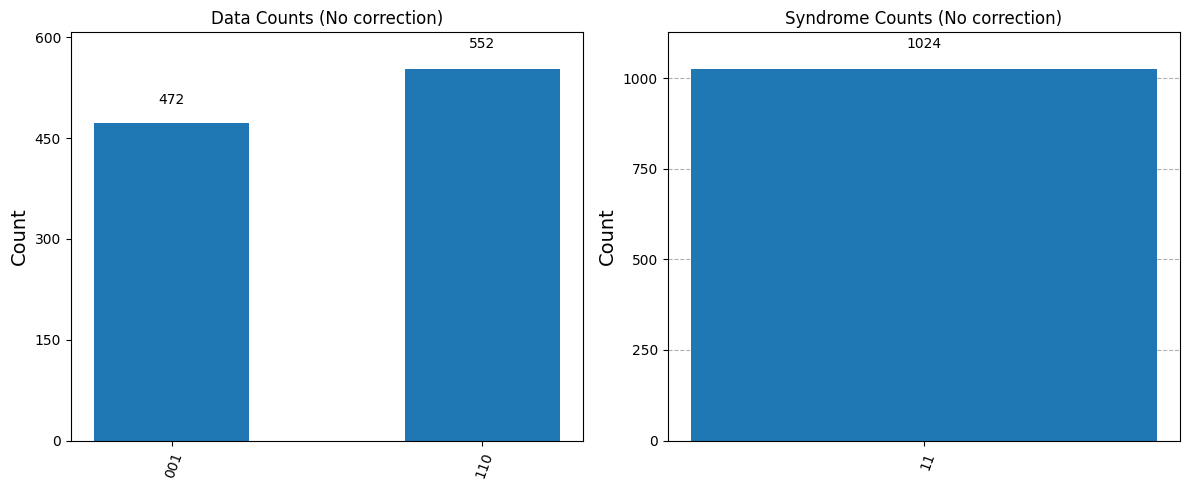

In [30]:
data_result, syndrome_result = plot_result(data_result, syndrome_result, False)

In [31]:
print(f'Completed bit code experiment data measurement counts (corrected): {data_result}')
print(f'Completed bit code experiment syndrome measurement counts (corrected): {syndrome_result}')
decode_result(data_result, syndrome_result)

Completed bit code experiment data measurement counts (corrected): {'110': 552, '001': 472}
Completed bit code experiment syndrome measurement counts (corrected): {'11': 1024}
Bit flip errors were detected/corrected on 1024/1024 trials.
A final parity error was detected on 1024/1024 trials.
